# Notebook R d'exemple utilisant l'API SAS Viya

## 1) On déclare la librairie SWAT permettant d'utiliser l'API R fournie par SAS Viya

In [1]:
library(swat)
library(ggplot2)

SWAT 1.6.3
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


## 2) Connexion au moteur CAS (Cloud Analytic Services) in-memory de la plateforme de Service Analytique SAS Viya

In [2]:
Sys.setenv(CAS_CLIENT_SSL_CA_LIST = "/opt/sas/viya/config/etc/SASSecurityCertificateFramework/cacerts/trustedcerts.pem")
conn <- CAS('frasepviya35smp.cloud.com', 5570)

# Activate session parameters if necessary
loadActionSet(conn, "fedSql")
loadActionSet(conn, "clustering")
loadActionSet(conn, "datastep")

cas.sessionProp.setSessOpt(conn, timeout=1800, caslib='casuser')

[1] "ERROR: Kerberos initialization failed. Your credential cache is either expired or missing."


ERROR: Error in reg.finalizer(ans@ref, delete_SW_CASConnection): trying to get slot "ref" from an object of a basic class ("NULL") with no slots


In [3]:
castbl <- cas.read.csv(conn, 'http://support.sas.com/documentation/onlinedoc/viya/exampledatasets/iris.csv')

[1] "NOTE: Cloud Analytic Services made the uploaded file available as table IRIS in caslib CASUSER(viyademo01)."


In [4]:
names(castbl)

[1] "Sepal.Length" "Sepal.Width"  "Petal.Length" "Petal.Width"  "Species"     
[6] "Index"

In [5]:
cas.clustering.kClus(conn, 
table=list(name="iris"),
nClusters=2,
init="RAND",
seed=534,
inputs=list("Sepal.Length", "Sepal.Width", "Petal.Length", "Petal.Width"),
output=list(casOut=list(name="kClusOutputScore", replace=TRUE),copyVars=list("Sepal.Length", "Sepal.Width","Petal.Length", "Petal.Width", "Species")),
printIter=FALSE,
impute="MEAN",
standardize='STD',
display=list(names=list("Nobs", "Modelinfo", "ClusterSum", "IterStats","DescStats", "WithinClusStats", "ClusterCenters")))

NOTE: Using SEED=534.
NOTE: Running for input data for K 2.
NOTE: Clustering is finished. STOPVALUE is satisfied for STOPCRITERION=CLUSTER_CHANGE.


$outputSize
$outputSize$outputNObs
[1] 150

$outputSize$outputNVars
[1] 8


$NObs
                         Type   N
1 Number of Observations Read 150
2 Number of Observations Used 150

$ModelInfo
                             RowId                       Parameter
1             Clustering_Algorithm            Clustering Algorithm
2               Maximum_Iterations              Maximum Iterations
3                   Stop_Criterion                  Stop Criterion
4             Stop_Criterion_Value            Stop Criterion Value
5                         Clusters                        Clusters
6                   Initialization                  Initialization
7                             Seed                            Seed
8  Distance_For_Interval_Variables Distance for Interval Variables
9                  Standardization                 Standardization
10             Interval_Imputation             Interval Imputation
          Setting
1         K-means
2              10
3  Cluster Change
4               0
5               2
6            Rand
7             534
8       Euclidean
9             Std
10           Mean

$DescStats
      Variable     Mean    StdDev
1 Sepal.Length 5.843333 0.8280661
2  Sepal.Width 3.054000 0.4335943
3 Petal.Length 3.758667 1.7644204
4  Petal.Width 1.198667 0.7631607

$WithinClusStats
      Variable Cluster       Mean    StdDev
1 Sepal.Length       1  0.5055957 0.8004608
2                    2 -1.0111914 0.4256782
3  Sepal.Width       1 -0.4197472 0.7674248
4                    2  0.8394944 0.8787578
5 Petal.Length       1  0.6502607 0.4679035
6                    2 -1.3005215 0.0983389
7  Petal.Width       1  0.6254689 0.5565911
8                    2 -1.2509379 0.1404809

$ClusterSum
  Cluster Frequency    MinDist  MaxDist   AvgDist       SSE StdDeviation
1       1       100 0.25137522 3.064436 1.1811502 174.08215    1.3194019
2       2        50 0.07427151 2.652510 0.8197914  48.15831    0.9814103
  NearestClus DBtwCentroids
1           2       3.34855
2           1       3.34855

$ClusterCenters
  _ITERATION_ _CLUSTER_ID_ Sepal.Length Sepal.Width Petal.Length Petal.Width
1           5            1        6.262       2.872        4.906       1.676
2           5            2        5.006       3.418        1.464       0.244
  S_Sepal_Length S_Sepal_Width S_Petal_Length S_Petal_Width
1      0.5055957    -0.4197472      0.6502607     0.6254689
2     -1.0111914     0.8394944     -1.3005215    -1.2509379

$IterStats
  IterationNum IterationSSE   SSEChange StopCriterion
1            0     576.1982         NaN           NaN
2            1     317.9806 -258.217596      13.33333
3            2     265.0254  -52.955146      10.00000
4            3     232.6914  -32.334019       4.00000
5            4     223.9428   -8.748636       2.00000
6            5     222.2405   -1.702298       0.00000

In [6]:
castbl2 <- defCasTable(conn, tablename="kClusOutputScore", caslib="casuser")
dfR <- to.casDataFrame(castbl2, obs = 10000000)

In [7]:
names(dfR)<-gsub("\\_","",names(dfR))
names(dfR)

[1] "Sepal.Length"         "Sepal.Width"          "Petal.Length"        
[4] "Petal.Width"          "Species"              "CLUSTERID"           
[7] "DISTANCE"             "STANDARDIZEDDISTANCE"

In [13]:
summary(dfR)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.054   Mean   :3.759   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
   Species            CLUSTERID        DISTANCE       STANDARDIZEDDISTANCE
 Length:150         Min.   :1.000   Min.   :0.05993   Min.   :0.07427     
 Class :character   1st Qu.:1.000   1st Qu.:0.44636   1st Qu.:0.63394     
 Mode  :character   Median :1.000   Median :0.72568   Median :0.93794     
                    Mean   :1.333   Mean   :0.85428   Mean   :1.06070     
                    3rd Qu.:2.000   3rd Qu.:1.10923   3rd Qu.:1.38415     
                    Max.   :2.000   Max.   :2.55093   Max.   :3.06444     

In [12]:
object.size(dfR)
str(dfR)

53016 bytes

'data.frame':	150 obs. of  8 variables:
Formal class 'casDataFrame' [package "swat"] with 15 slots
  ..@ .Data      :List of 8
  .. ..$ : num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
  .. ..$ : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
  .. ..$ : num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
  .. ..$ : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
  .. ..$ : chr  "setosa" "setosa" "setosa" "setosa" ...
  .. ..$ : num  2 2 2 2 2 2 2 2 2 2 ...
  .. ..$ : num  0.147 0.438 0.412 0.519 0.198 ...
  .. ..$ : num  0.231 0.975 0.633 0.884 0.425 ...
  ..@ name       : chr "_STANDARDIZED_DISTANCE_"
  ..@ label      : chr "Selected Rows from Table KCLUSOUTPUTSCORE"
  ..@ title      : chr "Selected Rows from Table KCLUSOUTPUTSCORE"
  ..@ attrs      :List of 3
  .. ..$ Action    : chr "fetch"
  .. ..$ Actionset : chr "table"
  .. ..$ CreateTime: num 1.95e+09
  ..@ col.labels : chr  "" "" "" "" ...
  ..@ col.formats: chr  "" "" "" "" ...
  ..@ col.attrs  : list()
  ..@ col.sizes  :List of 

In [10]:
dfR_pure <- to.data.frame(dfR)
object.size(dfR_pure)

27312 bytes

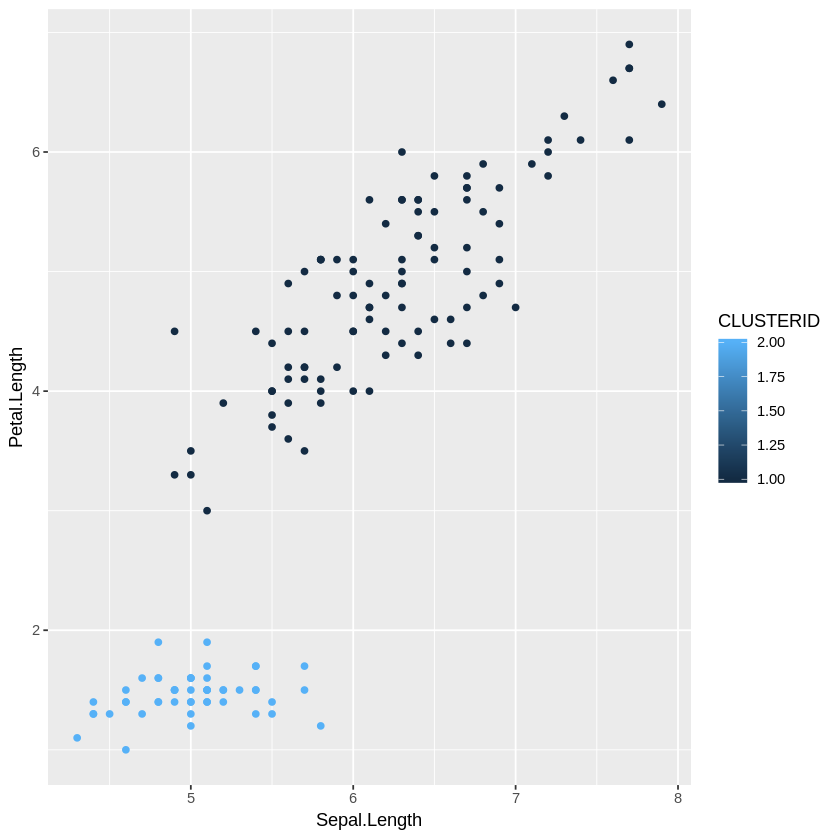

In [14]:
ggplot(dfR,aes(Sepal.Length, Petal.Length, col=CLUSTERID))+geom_point()

In [15]:
cas.session.endSession(conn)

list()